In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_, or_
from sqlalchemy import desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """   
  
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
for result in calc_temps(one_year_ago, last_date):
    print(f"Here are last year's Temperature Results:")
    print(f"Min temp : {result[0]}")
    print(f"Avg Temp : {round(result[1],2)}")
    print(f"Max temp : {result[2]}")

Here are last year's Temperature Results:
Min temp : 58.0
Avg Temp : 74.58
Max temp : 87.0


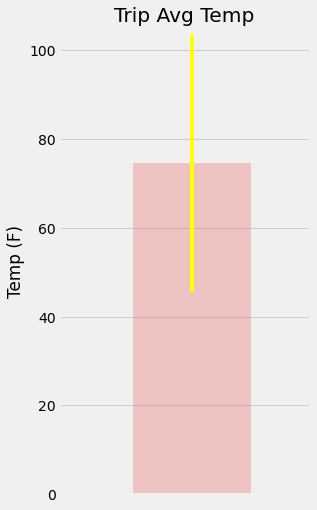

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_difference = lambda x, y: y-x
error_bar = peak_difference(result[0], result[2])
mean = result[1]
x_pos = 1    # the x locations for the groups

plt.figure(figsize=(4,8))
plt.xticks([])

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(.10 , 1.8)
plt.ylim(0,105)

plt.bar(x_pos, mean, yerr=error_bar, color='lightcoral', ecolor="yellow", align="center", alpha=0.4)
plt.savefig("Images/avg_temp_one_year.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_data = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation )\
                .filter(Measurement.station == Station.station)\
                .filter(and_(Measurement.date >= '2016-01-01', Measurement.date <= '2016-12-31'))\
                .group_by(Measurement.station).order_by(desc(func.sum(Measurement.prcp)))
rainfall_df = pd.DataFrame(rainfall_data, columns= ['total_rain', 'station', 'name', 'lat', 'lng','elevation'])
rainfall_df

,total_rain,station,name,lat,lng,elevation
0,162.88,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,79.89,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,52.15,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,30.77,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,27.29,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,16.15,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,2.97,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = (func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# Getting count of observation of each station
session.query(Measurement.station, func.count(Measurement.tobs))\
.filter(and_(func.strftime("%m-%d", Measurement.date) >= '08-01',func.strftime("%m-%d", Measurement.date) <= '08-07'))\
.group_by(Measurement.station).all()

[('USC00511918', 39),
 ('USC00513117', 49),
 ('USC00514830', 31),
 ('USC00516128', 53),
 ('USC00517948', 24),
 ('USC00518838', 12),
 ('USC00519281', 52),
 ('USC00519397', 56),
 ('USC00519523', 54)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'
 
# Use the start and end date to create a range of dates
mydates = []
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')
step = dt.timedelta(days=1)
while start <= end:
    mydates.append(start.date())
    start += step

# Strip off the year and save a list of strings in the format %m-%d
trip_dates = [dt.datetime.strftime(day,'%m-%d') for day in mydates]
    
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for day in trip_dates:
    normals.append(daily_normals(day))
    
print(f"Daily Normals for my Trip : {normals} ")

Daily Normals for my Trip : [[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]] 


In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp_df = pd.DataFrame({'date' : mydates,
                      'min' : [x[0][0] for x in normals],
                      'avg' : [x[0][1] for x in normals],
                      'max' : [x[0][2] for x in normals]}).set_index('date')
trip_temp_df

,min,avg,max
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


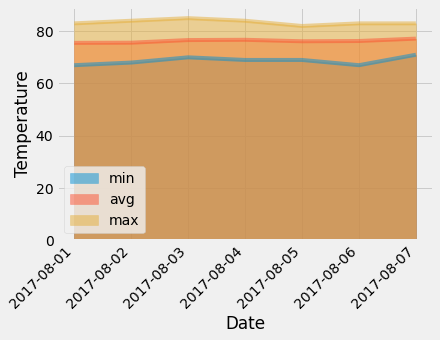

In [19]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp_df.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.xticks(rotation=45 , ha = 'right')
plt.savefig("Images/trip_temp.png")
plt.show()

## Close Session

In [18]:
# Close Session
session.close()